# HW07: Deep Learning (due 16th November)

In this homework, you will replicate the heterogenous treatment effect exercise from last week's homework using a deep learning model instead of a machine learning one.

For those who did not complete this exercise, you will investigate the effect of case management on mental health outcomes. These data come from a randomized control trial where patients were assigned to _intensive_ or _standard_ case management. In this context, the treatment is being assigned to the **intensive** case management while patients assigned to the **standard** case management belong to the control group.

We will investigate characteristics of individuals who are most and least responsive to the treatment, i.e., to being assigned to the intensive case management.


In [1]:
import pandas as pd
from tensorflow import keras


In [2]:
import pandas as pd
import statsmodels.formula.api as smf

df = pd.read_stata(
    'http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta')
df = df.dropna()
pd.read_stata('http://www.homepages.ucl.ac.uk/~rmjwiww/stata/missing/uk500.dta',
              iterator=True).variable_labels()


{'trialid': 'Trial ID',
 'centreid': 'Trial centre',
 'status': 'Patient status at baseline',
 'age': 'Age in years at baseline',
 'sex': 'Sex',
 'afcarib': 'Ethnic group',
 'ocfabth': "Father's social class at birth",
 'chron1l': 'Months since onset of psychosis, logged',
 'hos94': 'Days in hospital for psychiatric reasons: 2 years before baseline',
 'cprs94': 'Psychopathology at baseline (CPRS)',
 'das94': 'Disability at baseline (DAS)',
 'sat94': '(Dis)satisfaction with services at baseline',
 'rand': 'Randomised group',
 'hos96': 'Days in hospital for psychiatric reasons: 2 years after baseline',
 'cprs96': 'Psychopathology at 2 years (CPRS)',
 'sat96': '(Dis)satisfaction with services at 2 years'}

In [3]:
df.head()


,trialid,centreid,status,age,sex,afcarib,ocfabth,chron1l,hos94,cprs94,das94,sat94,rand,hos96,cprs96,sat96
1,107.0,St George's,Out-patient,27.0,male,Other,A,3.178054,80.0,4.0,0.285714,18.0,Intensive case management,27.0,3.0,22.000
2,222005.0,St Mary's,In hospital,41.0,male,Other,D,4.521789,240.0,6.0,0.750000,15.0,Intensive case management,15.0,13.0,9.000
3,222018.0,St Mary's,In hospital,25.0,male,Other,C2,4.094345,48.0,12.0,0.125000,18.0,Intensive case management,263.0,6.0,21.375
5,312015.0,King's,Out-patient,31.0,female,Other,A,4.787492,60.0,28.0,2.375000,20.0,Intensive case management,45.0,19.0,17.000
6,221023.0,St Mary's,In hospital,35.0,male,Afro-Caribbean,C2,4.430817,60.0,25.0,1.571428,24.0,Intensive case management,58.0,27.0,19.125


The treatment variable is $rand$, the post-treatment outcomes are $hos96$, $cprs96$ and $sat96$.


In [4]:
treatvar = 'rand'
df[treatvar].value_counts()


Intensive case management    130
Standard case management     116
Name: rand, dtype: int64

In [5]:
outcomes = ['sat96', 'hos96', 'cprs96']
df[outcomes].describe()


,sat96,hos96,cprs96
count,246.000000,246.000000,246.000000
mean,17.271341,65.500000,17.790587
std,4.723009,104.046722,14.090911
min,9.000000,0.000000,0.000000
25%,14.000000,0.000000,7.000000
50%,17.000000,15.000000,15.000000
75%,20.187500,93.500000,26.000000
max,32.000000,692.000000,71.000000


In addition to these variables we need a set of covariates that we want to use to identify individuals who are most and least responsive to treatment. We also encode categorical covariates and prepare them for the ML model.


In [6]:
# Encoding Categorical covariates and preparing the data for tensorflow
from sklearn.preprocessing import OrdinalEncoder
covariates = ['status', 'sex', 'sat94', 'ocfabth',
              'hos94', 'das94', 'cprs94', 'age', 'afcarib']
covariates_cat = ['status', 'sex', 'ocfabth', 'afcarib']

encoder = OrdinalEncoder()
df[covariates_cat] = encoder.fit_transform(df[covariates_cat])
df[covariates] = df[covariates].astype('float32')
df[covariates].head()


,status,sex,sat94,ocfabth,hos94,das94,cprs94,age,afcarib
1,1.0,1.0,18.0,0.0,80.0,0.285714,4.0,27.0,1.0
2,0.0,1.0,15.0,4.0,240.0,0.750000,6.0,41.0,1.0
3,0.0,1.0,18.0,3.0,48.0,0.125000,12.0,25.0,1.0
5,1.0,0.0,20.0,0.0,60.0,2.375000,28.0,31.0,1.0
6,0.0,1.0,24.0,3.0,60.0,1.571428,25.0,35.0,0.0


In [108]:
# Subset the dataset by treatment and control
# Within each sample, create a training, a test and a validation set

from sklearn.model_selection import train_test_split
df_treat = df[df[treatvar] == 'Intensive case management']
df_control = df[df[treatvar] == 'Standard case management']

Xt = df_treat[covariates]
Xc = df_control[covariates]
yt = df_treat[outcomes]
yc = df_control[outcomes]

# 60/20/20 split
Xt_train_val, Xt_test, yt_train_val, yt_test = train_test_split(
    Xt, yt, test_size=0.2)
Xc_train_val, Xc_test, yc_train_val, yc_test = train_test_split(
    Xc, yc, test_size=0.2)
Xt_train, Xt_val, yt_train, yt_val = train_test_split(
    Xt_train_val, yt_train_val, test_size=0.2)
Xc_train, Xc_val, yc_train, yc_val = train_test_split(
    Xc_train_val, yc_train_val, test_size=0.2)

Xt_train.dtypes

status     float32
sex        float32
sat94      float32
ocfabth    float32
hos94      float32
das94      float32
cprs94     float32
age        float32
afcarib    float32
dtype: object

Model: "sequential_260"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_790 (Dense)            (None, 31)                310       
_________________________________________________________________
batch_normalization_514 (Bat (None, 31)                124       
_________________________________________________________________
dropout_472 (Dropout)        (None, 31)                0         
_________________________________________________________________
dense_791 (Dense)            (None, 17)                544       
_________________________________________________________________
batch_normalization_515 (Bat (None, 17)                68        
_________________________________________________________________
dropout_473 (Dropout)        (None, 17)                0         
_________________________________________________________________
dense_792 (Dense)            (None, 1)              

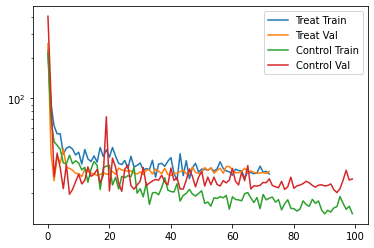

In [162]:
# choose one of the three outcomes to analyze
import matplotlib.pyplot as plt
from keras import initializers, regularizers
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping

outcome = ['sat96']

# build two MLP (multilayer perceptron) models to predict the outcome based on the covariates
# the first model should be trained on the treated sample, while the second on the control

# the two MLP models should have with at least 2 hidden layers, ReLU activation, batch normalization, dropout


%matplotlib inline


def construct(input_dim):
    model = Sequential()
    model.add(Dense(
        31,
        input_dim=input_dim,
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer='l2'
    ))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(17, activation='relu', kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='relu', kernel_initializer='he_normal'))
    return model


def compile(model: Sequential):
    model.compile(
        loss='mse',
        optimizer='sgd',
        metrics=['mse']
    )


def fit(model: Sequential, X_train, y_train, X_val, y_val):
    es = EarlyStopping(monitor='loss', patience=30)
    return model.fit(
        X_train,
        y_train,
        epochs=100,
        validation_data=(X_val, y_val),
        steps_per_epoch=8,
        callbacks=[es],
        use_multiprocessing=True
    )


# Create models
model_treat = construct(Xt.shape[1])
model_control = construct(Xc.shape[1])

model_treat.summary()

# compile the models
compile(model_treat)
compile(model_control)

# fit separate models on the treatment dataset and control dataset
# use early stopping
history_treat = fit(model_treat, Xt_train,
                    yt_train[outcome], Xt_val, yt_val[outcome])
history_control = fit(model_control, Xc_train,
                      yc_train[outcome], Xc_val, yc_val[outcome])

plt.yscale('log')
plt.plot(history_treat.epoch, history_treat.history['mse'])
plt.plot(history_treat.epoch, history_treat.history['val_mse'])
plt.plot(history_control.epoch, history_control.history['mse'])
plt.plot(history_control.epoch, history_control.history['val_mse'])
plt.legend(['Treat Train', 'Treat Val',
           'Control Train', 'Control Val'], loc='best')


In [172]:
def build_model(input_dim=Xt_train.shape[1], n_hidden=2, n_neurons=30, learning_rate=3e-3, batch_normalization=True, dropout=True, dropout_rate=.5):
    # Sequential model
    model = Sequential()
    # Input layer
    model.add(Dense(n_neurons, input_dim=input_dim, activation='relu'))
    # Hidden layers
    for _ in range(n_hidden):
        model.add(Dense(n_neurons, activation='relu'))
        if batch_normalization:
            model.add(BatchNormalization())
        if dropout:
            model.add(Dropout(dropout_rate))
    # Output layer
    model.add(Dense(1))
    optimizer= keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mse'])
    return model


def fit_pred(X_train, y_train, X_val, y_val, X_test, y_test):
    keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
    keras_reg.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
    mse_test = keras_reg.score(X_test, y_test)
    y_pred = keras_reg.predict(X_test)
    return mse_test, y_pred


mse_treat, yhat_treat = fit_pred(Xt_train, yt_train, Xt_val, yt_val, Xt_test, yt_test)
mse_control, yhat_control = fit_pred(Xc_train, yc_train, Xc_val, yc_val, Xc_test, yc_test)

print(mse_treat, mse_control)

Epoch 1/50
3/3 [==============================] - 1s 70ms/step - loss: 3961.7590 - mse: 3961.7590 - val_loss: 4508.0249 - val_mse: 4508.0249
Epoch 2/50
3/3 [==============================] - 0s 13ms/step - loss: 3835.6431 - mse: 3835.6431 - val_loss: 3949.8230 - val_mse: 3949.8230
Epoch 3/50
3/3 [==============================] - 0s 9ms/step - loss: 3615.5181 - mse: 3615.5181 - val_loss: 3824.3308 - val_mse: 3824.3308
Epoch 4/50
3/3 [==============================] - 0s 9ms/step - loss: 3394.4880 - mse: 3394.4880 - val_loss: 3776.7690 - val_mse: 3776.7690
Epoch 5/50
3/3 [==============================] - 0s 10ms/step - loss: 3140.9941 - mse: 3140.9941 - val_loss: 3740.9163 - val_mse: 3740.9163
Epoch 6/50
3/3 [==============================] - 0s 10ms/step - loss: 3048.9099 - mse: 3048.9099 - val_loss: 3910.1965 - val_mse: 3910.1965
Epoch 7/50
3/3 [==============================] - 0s 12ms/step - loss: 3104.0884 - mse: 3104.0884 - val_loss: 4111.2275 - val_mse: 4111.2275
Epoch 8/50
3/3 

In [164]:
# get predicted outcomes using the combined test sets for both models

test_set = Xt_test.append(Xc_test)
yhat_treat = model_treat.predict(test_set)
yhat_control = model_control.predict(test_set)

from sklearn.metrics import mean_squared_error

y_test = yt_test[outcome].append(yc_test[outcome])
print("MSE Treatment Group", mean_squared_error(y_test, yhat_treat))
print("MSE Control   Group", mean_squared_error(y_test, yhat_control))

# I really don't know why it's this bad


MSE Treatment Group 34.47403690946332
MSE Control   Group 28.43568055300351


In [165]:
# find the three individuals in the test set that are most and least responsive to the treatment
# namely the three individuals for who the treatment effect is larger and those for who it is smaller

test_set['treat_effect'] = yhat_treat - yhat_control
test_set.sort_values('treat_effect',ascending=False).head(3)


,status,sex,sat94,ocfabth,hos94,das94,cprs94,age,afcarib,treat_effect
7,1.0,0.0,20.0,3.0,730.0,0.400000,14.0,60.0,1.0,3.844763
299,1.0,1.0,22.0,3.0,4.0,0.500000,11.0,30.0,1.0,2.097727
466,1.0,1.0,19.0,3.0,331.0,0.142857,9.0,26.0,1.0,1.759014


In [ ]:
# visualize and comment on the covariates of these individuals
